# Analyse machine learning de fakes news

In [2]:
import re
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2024-02-15 10:54:45.492434: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 10:54:45.873796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 10:54:45.873860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 10:54:45.930605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 10:54:46.126413: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 10:54:46.138611: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Import des données

In [3]:
# Chargement du fichier CSV de test et nettoyage sommaire
df_test = pd.read_csv("test.csv")

In [4]:
# Chargement du fichier CSV de train et nettoyage sommaire
df_train = pd.read_csv("train.csv")

## Nettoyage des données
- suppression des données vide

In [5]:
df_test['Text'] = df_test['Text'].apply(lambda x : str(x).strip())
df_test = df_test.dropna()

df_train['Text'] = df_train['Text'].apply(lambda x : str(x).strip())
df_train = df_train.dropna()

- suppression des entrées non anglaise

In [6]:
from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'unknown'

In [7]:
df_test['lang'] = df_test['Text'].apply(detect_lang)
df_test['lang'].unique()

df_train['lang'] = df_test['Text'].apply(detect_lang)
df_train['lang'].unique()

df_train = df_train[df_train['lang'] == 'en'] # Keep only english reviews
df_test = df_test[df_test['lang'] == 'en'] # Keep only english reviews

- nettoyage de la colonne de texte avec passage de tout le texte en lowercase

In [8]:
def clean_data(text):
    # Remove all the special characters
    processed_text = re.sub(r'\W', ' ', text)
    # remove all single characters
    processed_text= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_text)
    # Remove single characters from the start
    processed_text = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_text)
    # Substituting multiple spaces with single space
    processed_text = re.sub(r'\s+', ' ', processed_text, flags=re.I)
    # Removing prefixed 'b'
    processed_text = re.sub(r'^b\s+', '', processed_text)
    # Converting to Lowercase
    processed_text = processed_text.lower()

    return processed_text

In [9]:
df_train = df_train.drop(columns={'lang'})
df_test = df_test.drop(columns={'lang'})

df_train = df_train.drop_duplicates(subset="Text")
df_test = df_test.drop_duplicates(subset="Text")

df_train['Text'] = df_train['Text'].apply(clean_data)
df_test['Text'] = df_test['Text'].apply(clean_data)


## Affichage des données nettoyées
- données d'entraînements

In [10]:
df_train

,Labels,Text,Text_Tag
0,1,says the annies list political group supports ...,abortion
1,2,when did the decline of coal start it started ...,"energy,history,job-accomplishments"
2,3,hillary clinton agrees with john mccain by vot...,foreign-policy
3,1,health care reform legislation is likely to ma...,health-care
4,2,the economic turnaround started at the end of ...,"economy,jobs"
...,...,...,...
1262,1,says new report proves the stimulus supported ...,stimulus
1263,4,says its absurd to say theres enough data to e...,"health-care,science,sports"
1264,1,the wives of the 9 11 hijackers knew exactly w...,"history,terrorism"
1265,4,says jill mccabe supports late term abortions ...,abortion


- données de tests

In [11]:
df_test

,Text,Text_Tag
0,building wall on the s mexico border will take...,immigration
1,wisconsin is on pace to double the number of l...,jobs
2,says john mccain has done nothing to help the ...,"military,veterans,voting-record"
3,suzanne bonamici supports plan that will cut c...,"medicare,message-machine-2012,campaign-adverti..."
4,when asked by reporter whether hes at the cent...,"campaign-finance,legal-issues,campaign-adverti..."
...,...,...
1262,says his budget provides the highest state fun...,education
1263,ive been here almost every day,"civil-rights,crime,criminal-justice"
1264,in the early 1980s sen edward kennedy secretly...,"bipartisanship,congress,foreign-policy,history"
1265,says an epa permit languished under strickland...,"environment,government-efficiency"


## Analyse des données nettoyées 

In [12]:
# Nombre de mots uniques

def findWordsCount(column):
    # Créer un ensemble pour stocker les mots
    mots = set()

    # Parcourir les reviews et ajouter chaque mot à l'ensemble
    for review in column:
        for word in review.split():
            mots.add(word)
    return len(mots)

print(f"Nombre de mots uniques dans les données de test : {findWordsCount(df_test['Text'])}")
print(f"Nombre de mots uniques dans les données de train : {findWordsCount(df_train['Text'])}")

Nombre de mots uniques dans les données de test : 4364
Nombre de mots uniques dans les données de train : 4303


### Répartition des labels
On observe que sur les données de test, les données des labels sont globalement équilibréés. Seule la catégorie 4 est sous-représentée.

In [13]:
counts_labels = df_train['Labels'].value_counts()
counts_labels

Labels
1    260
2    258
3    251
5    202
0    187
4    103
Name: count, dtype: int64

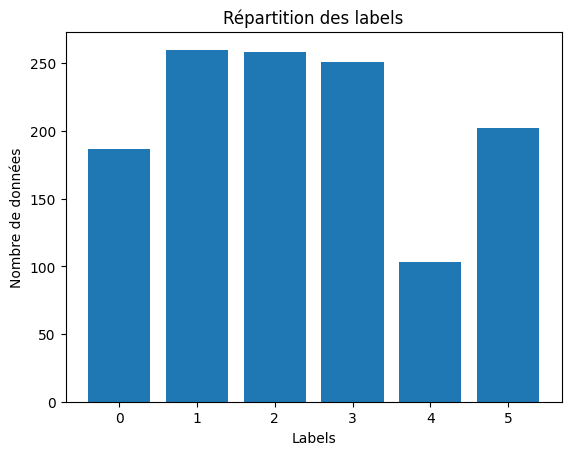

In [14]:
plt.bar(counts_labels.index, counts_labels.values)
plt.xlabel('Labels')
plt.ylabel('Nombre de données')
plt.title('Répartition des labels')
plt.show()

In [15]:
counts_tags = df_train['Text_Tag'].value_counts()
counts_tags

Text_Tag
taxes                                                                       41
immigration                                                                 38
education                                                                   36
health-care                                                                 35
elections                                                                   32
                                                                            ..
health-care,new-hampshire-2012,abc-news-week                                 1
immigration,military,terrorism                                               1
children,education,federal-budget,government-regulation                      1
city-government,civil-rights,criminal-justice,public-safety,state-budget     1
fake-news                                                                    1
Name: count, Length: 718, dtype: int64

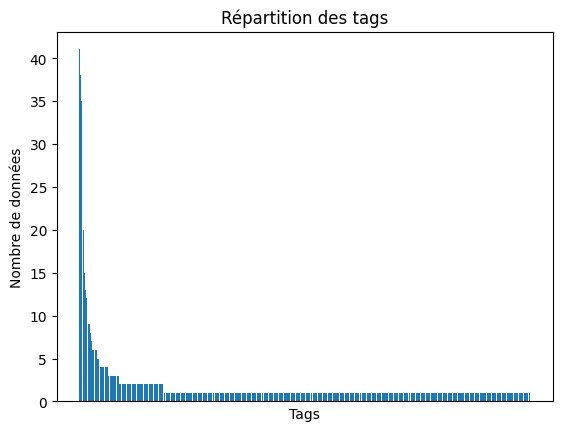

In [16]:
plt.bar(counts_tags.index, counts_tags.values)
plt.xlabel('Tags')
plt.ylabel('Nombre de données')
plt.title('Répartition des tags')
plt.xticks([])
plt.show()

On observe que certains tags sont beaucoup plus présents que d'autres mais nous pouvons également remarquer que certains tags sont composés. Il est donc difficile de tirer des informations pertinentes de ces données.

/tmp/ipykernel_13389/1006231693.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


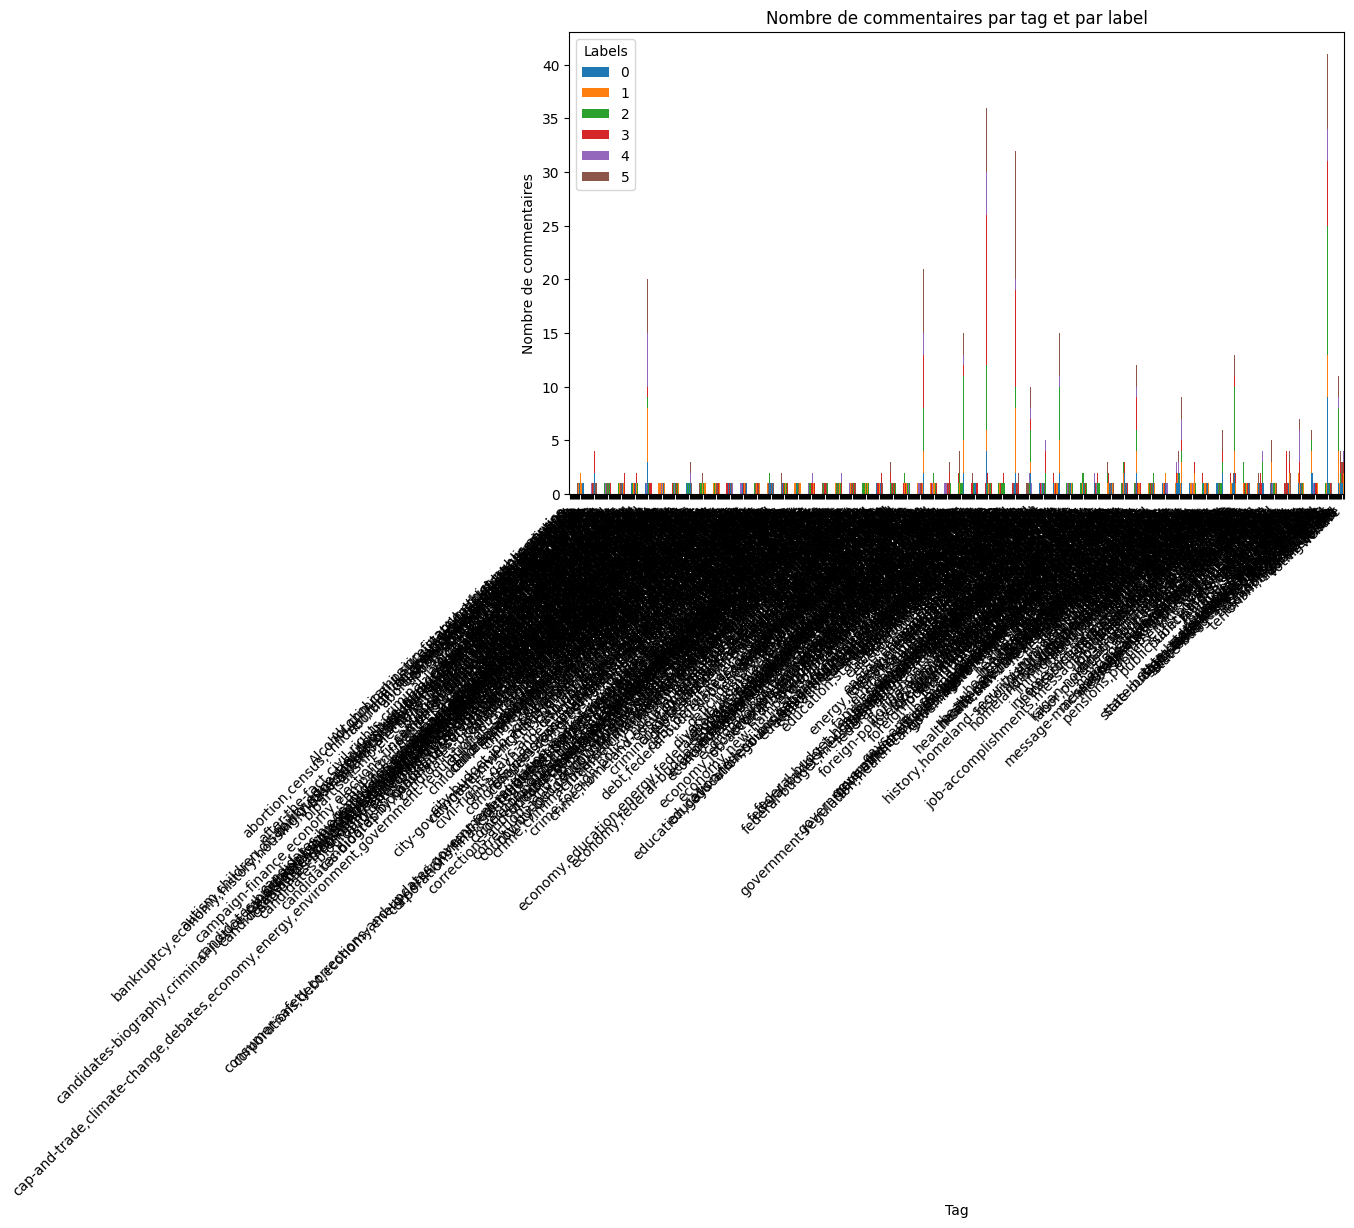

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Votre DataFrame contenant les données
# Supposons que votre DataFrame s'appelle df
# Et que vous voulez tracer le lien entre 'Text_Tag' et 'Labels'
# Vous pouvez adapter ceci à votre propre DataFrame

# Comptage du nombre de commentaires pour chaque tag et label
tag_label_counts = df_train.groupby(['Text_Tag', 'Labels']).size().unstack(fill_value=0)

# Tracer le graphique à barres
tag_label_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Nombre de commentaires par tag et par label')
plt.xlabel('Tag')
plt.ylabel('Nombre de commentaires')
plt.legend(title='Labels')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

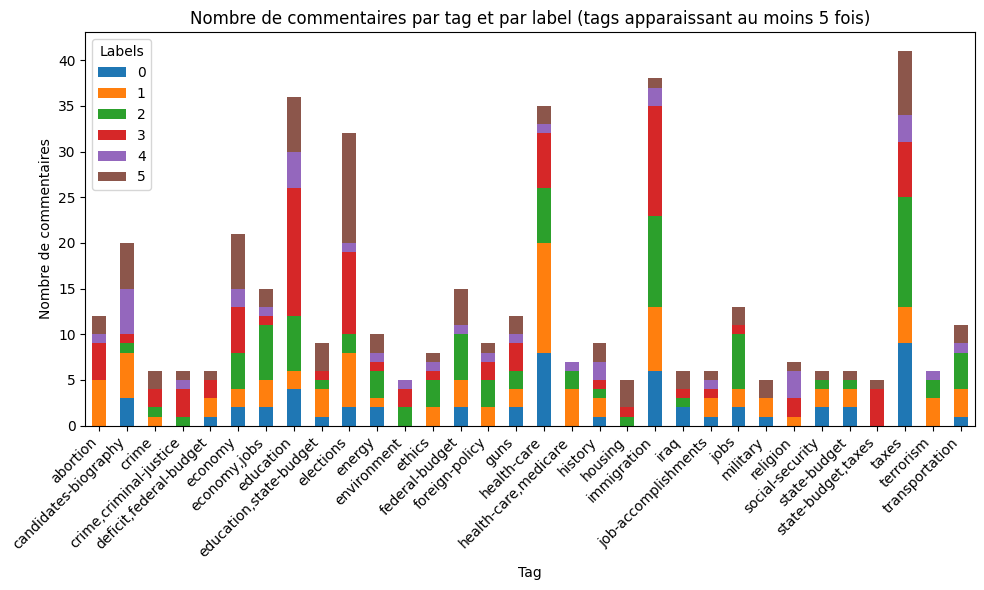

In [20]:
import matplotlib.pyplot as plt

# Compter le nombre d'occurrences de chaque tag
tag_counts = df_train['Text_Tag'].value_counts()

# Filtrer les tags qui apparaissent au moins 5 fois
tags_to_plot = tag_counts[tag_counts >= 5].index

# Filtrer le DataFrame original pour ne conserver que les lignes correspondant à ces tags
filtered_df = df_train[df_train['Text_Tag'].isin(tags_to_plot)]

# Comptage du nombre de commentaires pour chaque tag et label
tag_label_counts = filtered_df.groupby(['Text_Tag', 'Labels']).size().unstack(fill_value=0)

# Tracer le graphique à barres
tag_label_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Nombre de commentaires par tag et par label (tags apparaissant au moins 5 fois)')
plt.xlabel('Tag')
plt.ylabel('Nombre de commentaires')
plt.legend(title='Labels')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Etape de tokenisation

In [17]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

df_train['Tokens'] = df_train['Text'].apply(tokenize_text)
df_train

[nltk_data] Downloading package punkt to /home/sophie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Labels,Text,Text_Tag,Tokens
0,1,says the annies list political group supports ...,abortion,"[says, the, annies, list, political, group, su..."
1,2,when did the decline of coal start it started ...,"energy,history,job-accomplishments","[when, did, the, decline, of, coal, start, it,..."
2,3,hillary clinton agrees with john mccain by vot...,foreign-policy,"[hillary, clinton, agrees, with, john, mccain,..."
3,1,health care reform legislation is likely to ma...,health-care,"[health, care, reform, legislation, is, likely..."
4,2,the economic turnaround started at the end of ...,"economy,jobs","[the, economic, turnaround, started, at, the, ..."
...,...,...,...,...
1262,1,says new report proves the stimulus supported ...,stimulus,"[says, new, report, proves, the, stimulus, sup..."
1263,4,says its absurd to say theres enough data to e...,"health-care,science,sports","[says, its, absurd, to, say, theres, enough, d..."
1264,1,the wives of the 9 11 hijackers knew exactly w...,"history,terrorism","[the, wives, of, the, 9, 11, hijackers, knew, ..."
1265,4,says jill mccabe supports late term abortions ...,abortion,"[says, jill, mccabe, supports, late, term, abo..."
